# 1. Traitement des données

## 1.1. Chargement des données

In [1]:
%%info

In [2]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.functions import array_to_vector
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql.types import StructType, StructField, StringType, FloatType
from pyspark.sql.functions import when

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
3,application_1678741197838_0004,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
PATH = 's3://p8-data-mochan97'
PATH_Data = PATH+'/Test'
PATH_Result = PATH+'/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://p8-data-mochan97
PATH_Data:   s3://p8-data-mochan97/Test
PATH_Result: s3://p8-data-mochan97/Results

In [5]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://p8-data-moch...|2023-03-04 17:03:53|  6894|[FF D8 FF E0 00 1...|
|s3://p8-data-moch...|2023-03-04 17:03:53|  6817|[FF D8 FF E0 00 1...|
|s3://p8-data-moch...|2023-03-04 17:03:53|  6785|[FF D8 FF E0 00 1...|
|s3://p8-data-moch...|2023-03-04 17:03:53|  6761|[FF D8 FF E0 00 1...|
|s3://p8-data-moch...|2023-03-04 17:03:53|  6741|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

In [7]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+---------------------------------------------------+----------+
|path                                               |label     |
+---------------------------------------------------+----------+
|s3://p8-data-mochan97/Test/Watermelon/r_116_100.jpg|Watermelon|
|s3://p8-data-mochan97/Test/Watermelon/211_100.jpg  |Watermelon|
|s3://p8-data-mochan97/Test/Watermelon/r_188_100.jpg|Watermelon|
|s3://p8-data-mochan97/Test/Watermelon/r_81_100.jpg |Watermelon|
|s3://p8-data-mochan97/Test/Watermelon/155_100.jpg  |Watermelon|
+---------------------------------------------------+----------+
only showing top 5 rows

None

## 1.2. Préparation du modèle

In [8]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [12]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 1.3. Définition du processus de chargement des images <br/> et application de leur featurisation à travers l'utilisation de pandas UDF

In [13]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)


def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt/yarn/usercache/livy/appcache/application_1678741197838_0004/container_1678741197838_0004_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:398: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

## 1.4. Exécutions des actions d'extractions de features

In [14]:
features_df = images.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
print(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://p8-data-mochan97/Results

In [16]:
features_df.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 1.5. Chargement des données enregistrées et validation du résultat

In [17]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                path  ...                                           features
0  s3://p8-data-mochan97/Test/Apple Golden 1/45_1...  ...  [0.0, 0.11814929, 0.0, 0.0, 0.21668012, 0.1822...
1      s3://p8-data-mochan97/Test/Orange/146_100.jpg  ...  [0.029065793, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....
2    s3://p8-data-mochan97/Test/Tomato 1/100_100.jpg  ...  [0.0, 0.29381076, 0.0, 0.006408886, 0.0600482,...
3      s3://p8-data-mochan97/Test/Avocado/11_100.jpg  ...  [0.5360845, 0.0035986316, 0.0, 0.0, 0.0, 0.223...
4    s3://p8-data-mochan97/Test/Banana/r_103_100.jpg  ...  [1.9642231, 0.058090046, 0.0, 0.006789353, 0.1...

[5 rows x 3 columns]

In [19]:
df.loc[0,'features'].shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1280,)

In [20]:
df.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(100, 3)

On peut également confirmer la présence des fichiers au format "**parquet**" sur le **serveur S3** :
    
    
    

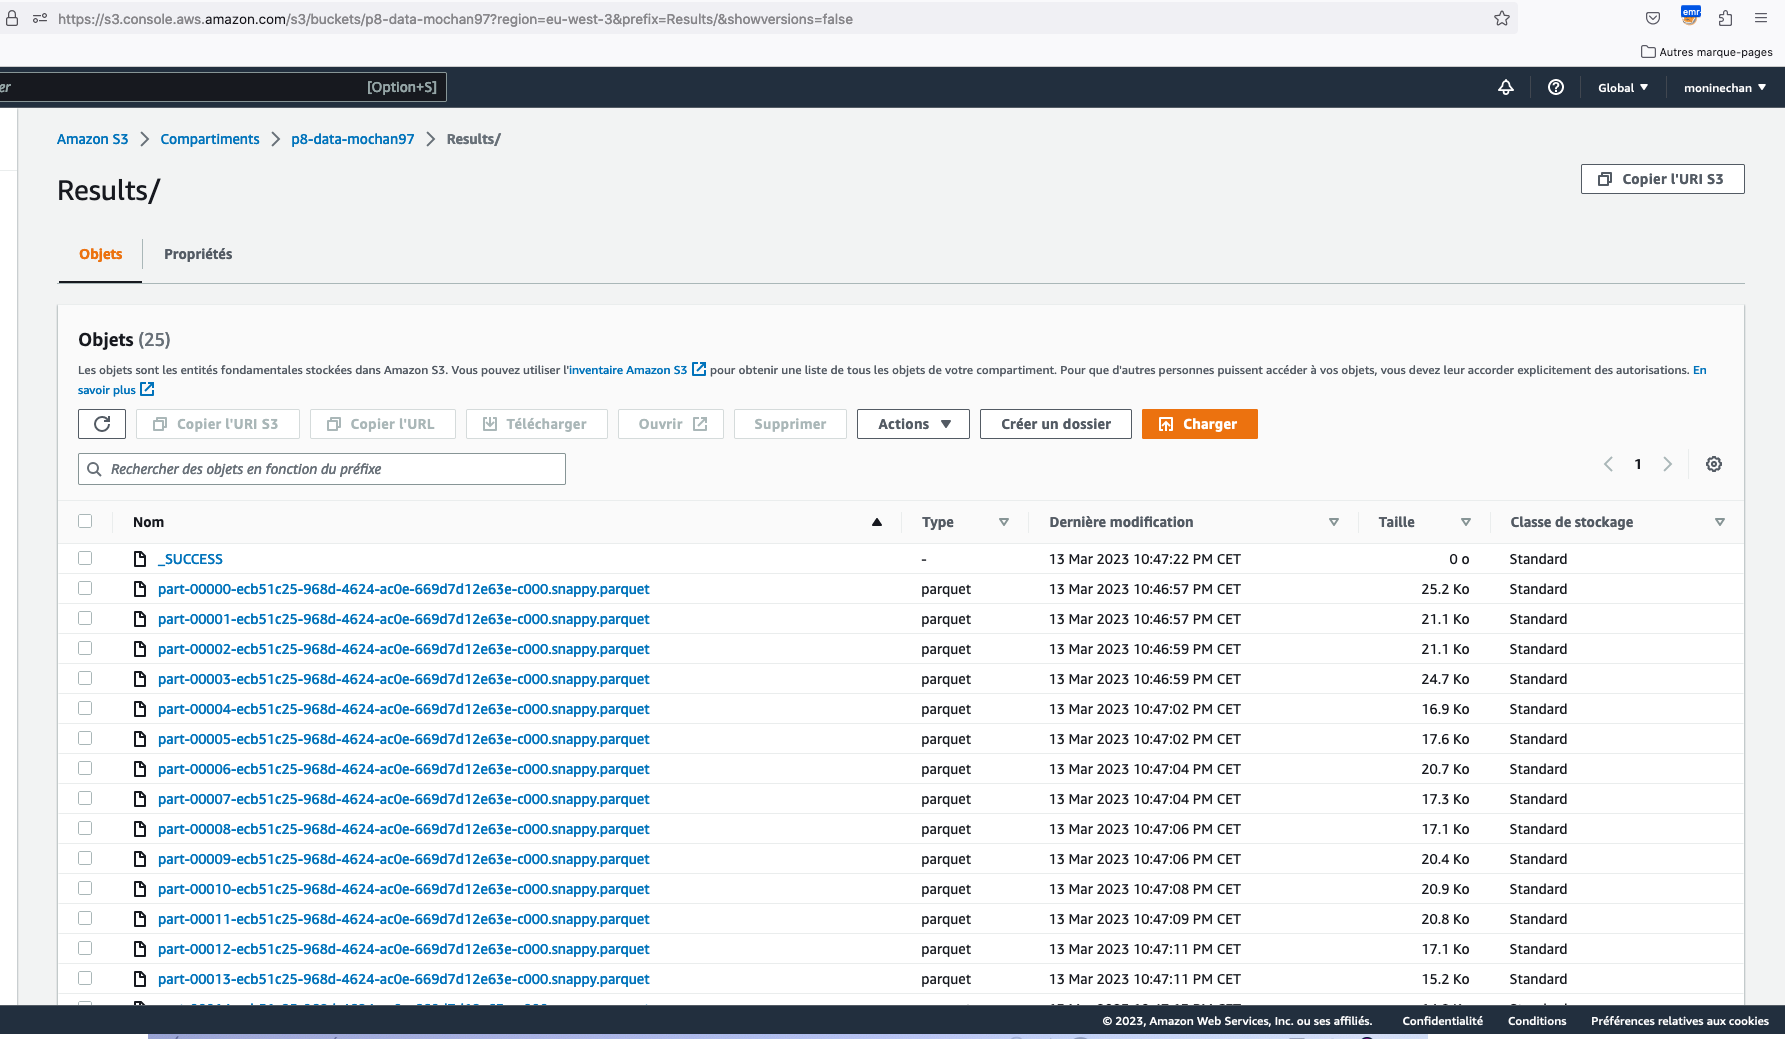

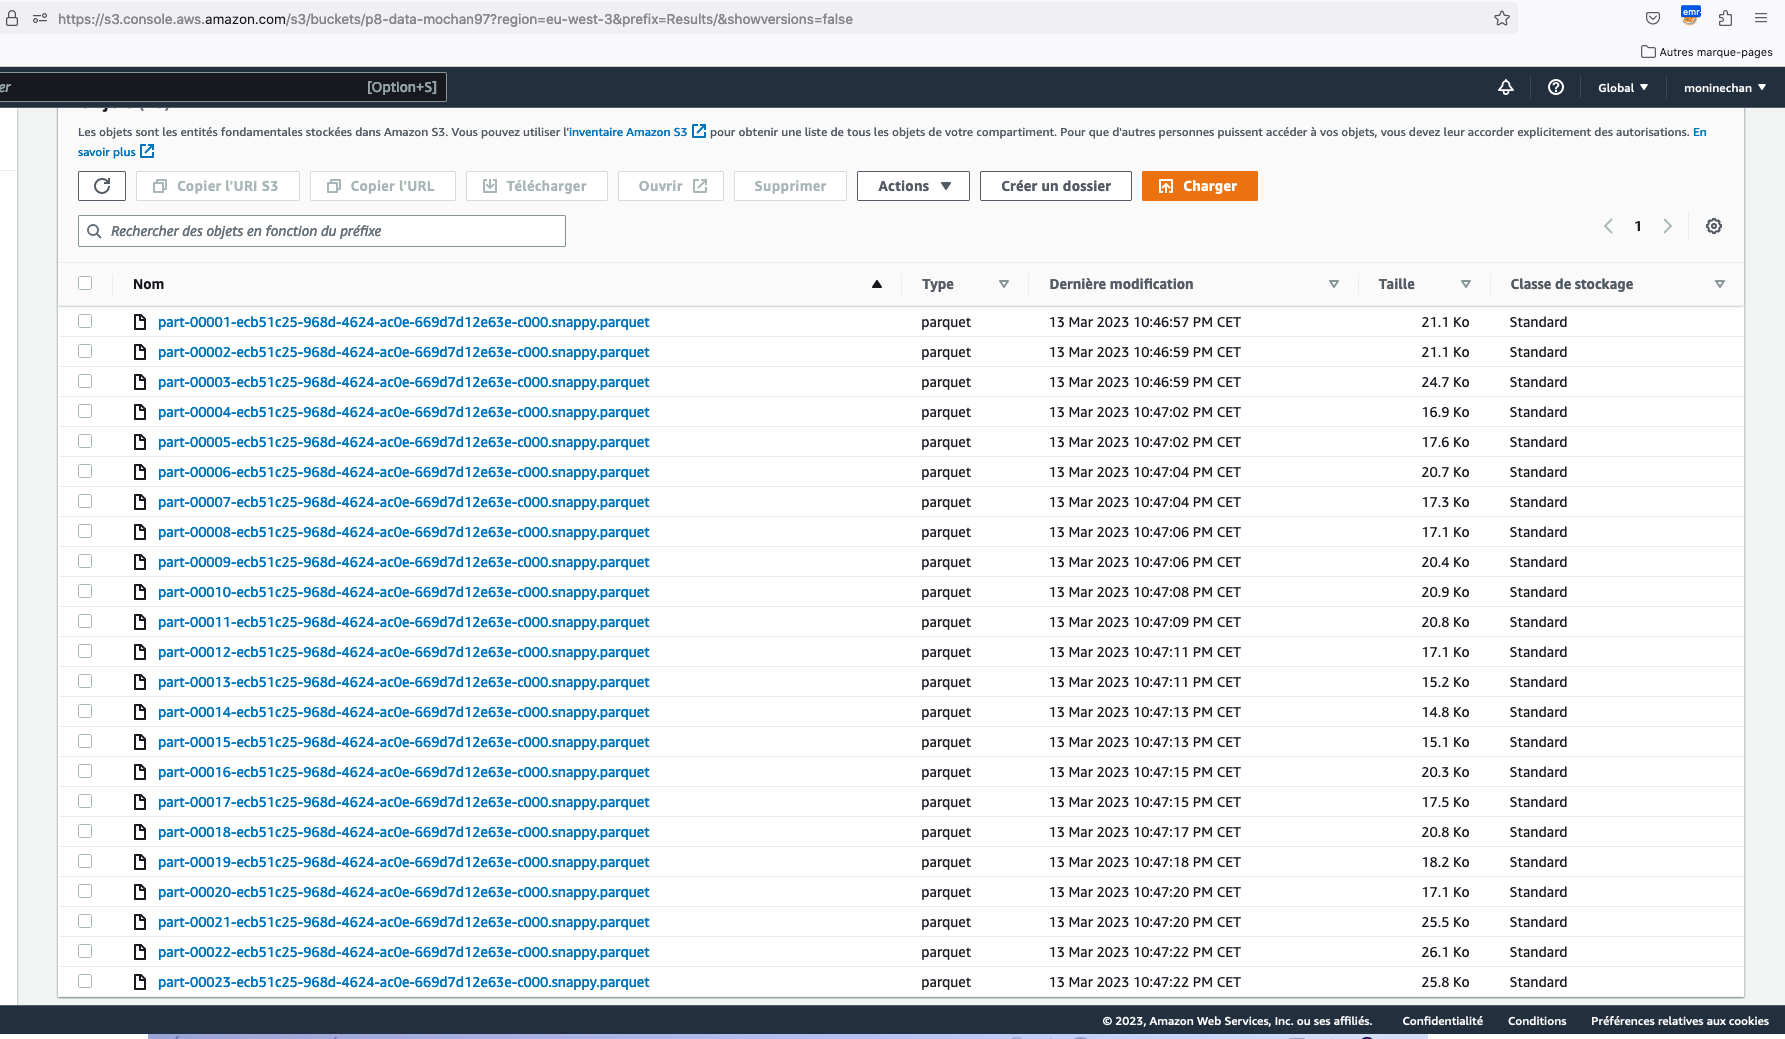

In [21]:
type(df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>

In [22]:
df.to_csv(PATH + '/df_avec_features.csv')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 2. PCA

Nous devons effectuer une réduction de dimensions de type PCA en PySpark.

## 2.1. Préparation des données pour la PCA

In [23]:
df_spark = spark.read.parquet(PATH_Result, engine='pyarrow')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
type(df_spark)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.sql.dataframe.DataFrame'>

In [25]:
df_spark.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)

In [26]:
df_spark.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+--------------------+
|                path|     label|            features|
+--------------------+----------+--------------------+
|s3://p8-data-moch...| Mangostan|[0.90205336, 0.0,...|
|s3://p8-data-moch...|Watermelon|[3.735873E-5, 0.0...|
|s3://p8-data-moch...|  Tomato 1|[0.0, 0.7510508, ...|
|s3://p8-data-moch...| Mangostan|[0.073553056, 0.0...|
|s3://p8-data-moch...| Blueberry|[0.0062133437, 0....|
+--------------------+----------+--------------------+
only showing top 5 rows

# 2.2. Implementation de la PCA

In [27]:
df_spark_V2 = df_spark.select(array_to_vector('features').alias('features'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
scaler = StandardScaler(
    inputCol = 'features', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(df_spark_V2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
# when we transform the dataframe, the old
# feature will still remain in it
df_spark_scaled = scaler.transform(df_spark_V2)
df_spark_scaled.show(6)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[0.90205335617065...|[0.64661076170168...|
|[3.73587317881174...|[-0.8760099784895...|
|[0.0,0.7510507702...|[-0.8760730407634...|
|[0.07355305552482...|[-0.7519140367495...|
|[0.00621334370225...|[-0.8655847944198...|
|[1.05945217609405...|[0.91230306469572...|
+--------------------+--------------------+
only showing top 6 rows

In [30]:
n_components = 2
pca = PCA(
    k = n_components, 
    inputCol = 'scaledFeatures', 
    outputCol = 'pcaFeatures'
).fit(df_spark_scaled)

df_spark_pca = pca.transform(df_spark_scaled)
print('Explained Variance Ratio', pca.explainedVariance.toArray())


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Explained Variance Ratio [0.11016869 0.0722545 ]

In [31]:
pca.explainedVariance

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DenseVector([0.1102, 0.0723])

In [32]:
datax = [("PC1", float(0.11016869)), ("PC2", float(0.0722545))]
schema = StructType([
    StructField("principal component", StringType(), True),
    StructField("explained variance", FloatType(), True)
])

df_explained_variance = spark.createDataFrame(datax, schema)
df_explained_variance.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------------------+
|principal component|explained variance|
+-------------------+------------------+
|                PC1|        0.11016869|
|                PC2|         0.0722545|
+-------------------+------------------+

In [33]:
df_pd_explained_variance = df_explained_variance.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
fig1 = plt.figure("% of Explained Variance")
df_pd_explained_variance.plot.bar(x='principal component', y='explained variance')  

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:xlabel='principal component'>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

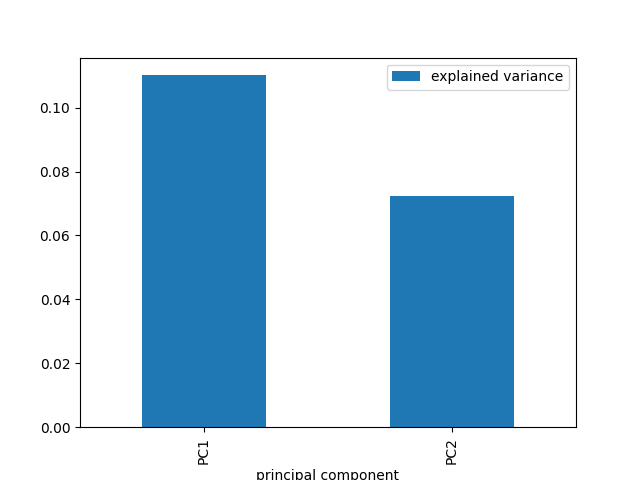

In [35]:
%matplot plt

In [36]:
df_spark_pca.show(6)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+
|            features|      scaledFeatures|         pcaFeatures|
+--------------------+--------------------+--------------------+
|[0.90205335617065...|[0.64661076170168...|[7.65338457768209...|
|[3.73587317881174...|[-0.8760099784895...|[4.68067286130785...|
|[0.0,0.7510507702...|[-0.8760730407634...|[2.21835261465168...|
|[0.07355305552482...|[-0.7519140367495...|[3.63723703159508...|
|[0.00621334370225...|[-0.8655847944198...|[3.07266391774062...|
|[1.05945217609405...|[0.91230306469572...|[-0.7055505290071...|
+--------------------+--------------------+--------------------+
only showing top 6 rows

In [37]:
from pyspark.sql.functions import monotonically_increasing_id

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
# add unique ids to both dataframes to avoid column name conflicts
df_spark_pca_V2 = df_spark_pca.withColumn("id", monotonically_increasing_id())
df_spark_V2 = df_spark.withColumn("id", monotonically_increasing_id())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
df_spark_pca_V2.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+---+
|            features|      scaledFeatures|         pcaFeatures| id|
+--------------------+--------------------+--------------------+---+
|[0.90205335617065...|[0.64661076170168...|[7.65338457768209...|  0|
|[3.73587317881174...|[-0.8760099784895...|[4.68067286130785...|  1|
|[0.0,0.7510507702...|[-0.8760730407634...|[2.21835261465168...|  2|
|[0.07355305552482...|[-0.7519140367495...|[3.63723703159508...|  3|
|[0.00621334370225...|[-0.8655847944198...|[3.07266391774062...|  4|
+--------------------+--------------------+--------------------+---+
only showing top 5 rows

In [40]:
df_spark_V2.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+--------------------+---+
|                path|     label|            features| id|
+--------------------+----------+--------------------+---+
|s3://p8-data-moch...| Mangostan|[0.90205336, 0.0,...|  0|
|s3://p8-data-moch...|Watermelon|[3.735873E-5, 0.0...|  1|
|s3://p8-data-moch...|  Tomato 1|[0.0, 0.7510508, ...|  2|
|s3://p8-data-moch...| Mangostan|[0.073553056, 0.0...|  3|
|s3://p8-data-moch...| Blueberry|[0.0062133437, 0....|  4|
+--------------------+----------+--------------------+---+
only showing top 5 rows

In [41]:
# join the dataframes on the "id" column
df_combined = df_spark_V2.join(df_spark_pca_V2.select(["id", "pcaFeatures"]), on=["id"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
type(df_combined)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.sql.dataframe.DataFrame'>

In [43]:
# show the resulting dataframe
df_combined.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+--------------------+----------+--------------------+--------------------+
| id|                path|     label|            features|         pcaFeatures|
+---+--------------------+----------+--------------------+--------------------+
|  0|s3://p8-data-moch...| Mangostan|[0.90205336, 0.0,...|[7.65338457768209...|
|  1|s3://p8-data-moch...|Watermelon|[3.735873E-5, 0.0...|[4.68067286130785...|
|  2|s3://p8-data-moch...|  Tomato 1|[0.0, 0.7510508, ...|[2.21835261465168...|
|  3|s3://p8-data-moch...| Mangostan|[0.073553056, 0.0...|[3.63723703159508...|
|  4|s3://p8-data-moch...| Blueberry|[0.0062133437, 0....|[3.07266391774062...|
|  5|s3://p8-data-moch...|Strawberry|[1.0594522, 0.005...|[-0.7055505290071...|
|  6|s3://p8-data-moch...|Watermelon|[0.005892092, 0.0...|[4.83553598206552...|
|  7|s3://p8-data-moch...|      Pear|[1.3890997, 0.0, ...|[6.50197776061443...|
|  8|s3://p8-data-moch...|      Pear|[1.6463169, 0.0, ...|[5.70758993805217...|
|  9|s3://p8-data-moch...| Blueberry|[1.

In [44]:
df_spark_pca_V2.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+---+
|            features|      scaledFeatures|         pcaFeatures| id|
+--------------------+--------------------+--------------------+---+
|[0.90205335617065...|[0.64661076170168...|[7.65338457768209...|  0|
|[3.73587317881174...|[-0.8760099784895...|[4.68067286130785...|  1|
|[0.0,0.7510507702...|[-0.8760730407634...|[2.21835261465168...|  2|
|[0.07355305552482...|[-0.7519140367495...|[3.63723703159508...|  3|
|[0.00621334370225...|[-0.8655847944198...|[3.07266391774062...|  4|
|[1.05945217609405...|[0.91230306469572...|[-0.7055505290071...|  5|
|[0.00589209189638...|[-0.8661270737849...|[4.83553598206552...|  6|
|[1.38909971714019...|[1.46875459590475...|[6.50197776061443...|  7|
|[1.64631688594818...|[1.90294223456340...|[5.70758993805217...|  8|
|[1.15627765655517...|[1.07574637961218...|[10.0669404641895...|  9|
+--------------------+--------------------+--------------------+---+
only showing top 10 rows

In [45]:
X_pca = df_combined.rdd.map(lambda row: row.pcaFeatures).collect()
X_pca = np.array(X_pca)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
X_pca[0:9,]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([[  7.65338458,   4.01700113],
       [  4.68067286,  -3.50275503],
       [  2.21835261,  16.17556074],
       [  3.63723703,   5.46800937],
       [  3.07266392,  20.22709689],
       [ -0.70555053,   1.10354477],
       [  4.83553598,  -0.94416636],
       [  6.50197776, -13.62920535],
       [  5.70758994, -14.61807177]])

In [47]:
df_combined = df_combined.withColumn('Target', when(df_combined.label == 'Apple Golden 1', 1)
                                          .when(df_combined.label == 'Avocado', 2)
                                          .when(df_combined.label == 'Banana', 3)
                                          .when(df_combined.label == 'Blueberry', 4)
                                          .when(df_combined.label == 'Mangostan', 5)
                                          .when(df_combined.label == 'Orange', 6)
                                          .when(df_combined.label == 'Pear', 7)
                                          .when(df_combined.label == 'Strawberry', 8)
                                          .when(df_combined.label == 'Tomato 1', 9)
                                          .when(df_combined.label == 'Watermelon', 10)
                                          .otherwise(0))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
df_combined.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+--------------------+----------+--------------------+--------------------+------+
| id|                path|     label|            features|         pcaFeatures|Target|
+---+--------------------+----------+--------------------+--------------------+------+
|  0|s3://p8-data-moch...| Mangostan|[0.90205336, 0.0,...|[7.65338457768209...|     5|
|  1|s3://p8-data-moch...|Watermelon|[3.735873E-5, 0.0...|[4.68067286130785...|    10|
|  2|s3://p8-data-moch...|  Tomato 1|[0.0, 0.7510508, ...|[2.21835261465168...|     9|
|  3|s3://p8-data-moch...| Mangostan|[0.073553056, 0.0...|[3.63723703159508...|     5|
|  4|s3://p8-data-moch...| Blueberry|[0.0062133437, 0....|[3.07266391774062...|     4|
|  5|s3://p8-data-moch...|Strawberry|[1.0594522, 0.005...|[-0.7055505290071...|     8|
|  6|s3://p8-data-moch...|Watermelon|[0.005892092, 0.0...|[4.83553598206552...|    10|
|  7|s3://p8-data-moch...|      Pear|[1.3890997, 0.0, ...|[6.50197776061443...|     7|
|  8|s3://p8-data-moch...|      Pear|[1.646

In [49]:
y = df_combined.rdd.map(lambda row: row.Target).collect()
y = np.array(y)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
len(y)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

100

In [51]:
len(X_pca)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

100

In [52]:
y[0:10,]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([ 5, 10,  9,  5,  4,  8, 10,  7,  7,  4])

In [53]:
X_pca[0:10,]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([[  7.65338458,   4.01700113],
       [  4.68067286,  -3.50275503],
       [  2.21835261,  16.17556074],
       [  3.63723703,   5.46800937],
       [  3.07266392,  20.22709689],
       [ -0.70555053,   1.10354477],
       [  4.83553598,  -0.94416636],
       [  6.50197776, -13.62920535],
       [  5.70758994, -14.61807177],
       [ 10.06694046,  16.007625  ]])

In [54]:
def plot_pca(X_pca, y):
    plt.clf()
    fig2 = plt.figure(figsize=(8,6))
    markers = 'x', 'x', 'd', 'o', '^', 'v', '*', '*', 'x', '+'
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors[:10])
    colors = list(plt.rcParams['axes.prop_cycle'])
    
    label_dict = {1: 'Apple Golden 1', 2: 'Avocado', 3: 'Banana', 4: 'Blueberry', 
                  5: 'Mangostan', 6: 'Orange', 7: 'Pear', 8: 'Strawberry', 
                  9: 'Tomato 1', 10: 'Watermelon'}
    
    target = np.unique(y)
    handles = []
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X_pca[y == t]
        handle = plt.scatter(subset[:, 0], subset[:, 1], s=20,
                             c=colors[idx]['color'], label=label_dict[t], marker=m)
        handles.append(handle)
    
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.tight_layout()
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.3)
    plt.legend(handles=handles, loc='center left', bbox_to_anchor=(0.5, 0.75), borderaxespad=-20.0)
    plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
plot_pca(X_pca, y)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

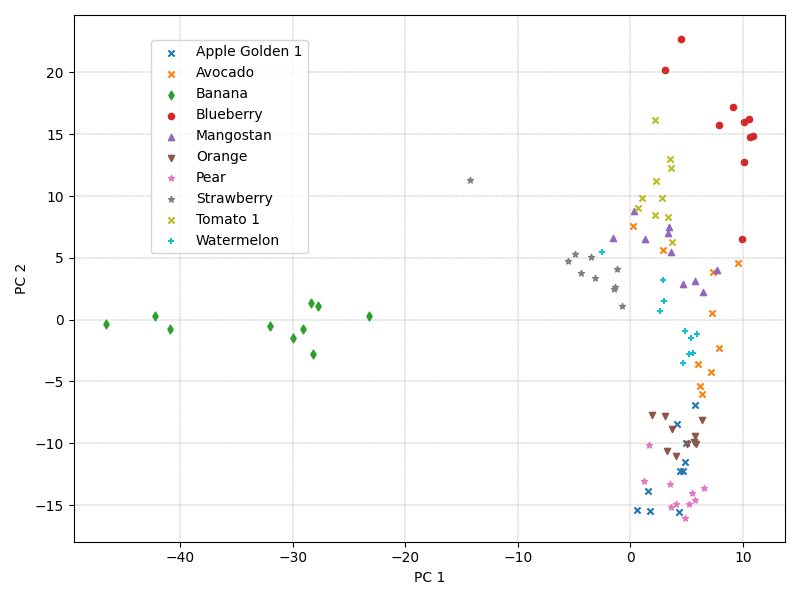

In [56]:
%matplot plt